In [703]:
import sys
import sqlite3
import math
import warnings
import struct
import itertools
import numpy as np
import scipy.fftpack
import scipy.signal
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.dates
import scipy.optimize
%matplotlib notebook

In [704]:
db = sqlite3.connect('test_run.sqlite3')

In [705]:
#last_run, = db.execute('SELECT MAX(run_id) FROM packets').fetchone()
# Override
#last_run = 40
last_run=33

In [706]:
num_packets, = db.execute('SELECT COUNT(*) FROM packets WHERE run_id=?', (last_run,)).fetchone()
num_packets_distinct, = db.execute('SELECT COUNT(*) FROM (SELECT DISTINCT data FROM packets WHERE run_id=?)', (last_run,)).fetchone()
timespan_start, timespan_end = db.execute('SELECT MIN(timestamp_us)/1e6, MAX(timestamp_us)/1e6 FROM packets WHERE run_id=?', (last_run,)).fetchone()
timespan = timespan_end - timespan_start
print(f'Last run was ID #{last_run} with {num_packets} packets total, {num_packets_distinct} distinct over {timespan}s')

Last run was ID #33 with 3178 packets total, 125 distinct over 99.94346904754639s


In [707]:
timestamps = db.execute('SELECT timestamp_us/1e6 FROM packets WHERE run_id=? ORDER BY timestamp_us', (last_run,)).fetchall()
timestamps = [ ts - timespan_start for ts, in timestamps ]
deltas = [ b-a for a, b in zip(timestamps[:-1], timestamps[1:]) ]

<IPython.core.display.Javascript object>


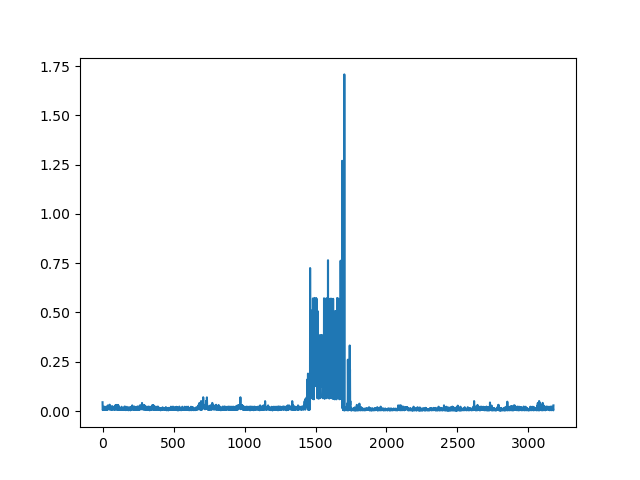

In [708]:
fig, ax = plt.subplots()
ax.plot(deltas)

In [709]:
packet_lengths = db.execute('SELECT LENGTH(data) FROM packets WHERE run_id=? GROUP BY LENGTH(data)', (last_run,)).fetchall()
assert len(packet_lengths) == 1
packet_len, = packet_lengths[0]
print('Packet length:', packet_len)

Packet length: 40


In [710]:
#approx_baudrate = 1.0 / (np.mean([ x for x in deltas if x < interval*0.02]) / (packet_len*10))
approx_baudrate = 1.0 / (0.0031 / (packet_len*10))
print(f'Very approximate lower bound on baudrate: {approx_baudrate} bd')

Very approximate lower bound on baudrate: 129032.25806451612 bd


In [711]:
def decode_packet(packet):
    seq, *data, _crc = struct.unpack('<I16hI', packet)
    return (seq, tuple(data))

packets = sorted([ decode_packet(data) for data, in db.execute('SELECT data FROM packets WHERE run_id=?', (last_run,)) ])

In [712]:
# group packets by sequence number
by_seq = { k: list(g) for k, g in itertools.groupby(packets, key=lambda x: x[0]) }
for seq, le_packets in by_seq.items():
    # make sure we only ever have one version of a packet with a particular sequence number (no CRC collisions)
    if len(set(le_packets)) > 1:
        # In test_run.sqlite3 run 2 this happens to coincide with the time I intentionally bumped the rotor... ?
        warnings.warn(f'BUG: Duplicate sequence number {seq} for {len(set(le_packets))} payloads!')
        print('BUG: Duplicate sequence number')
        print('Sequence number:', seq)
        for seq, data in set(le_packets):
            print('   ', data)

In [713]:
seqs = list(by_seq)
print(f'Sequence number range: {min(seqs)} ... {max(seqs)}')

Sequence number range: 35 ... 161


In [714]:
# FIXME this is only approximate, doesn't consider sequence numbers properly!!!
# Negate values: Our sensor is mounted such that -X points outwards,
# so by negating we get larger centrifugal force -> higher value
reassembled_values = np.array([ -val for (_seq, values), *_rest in by_seq.values() for val in values[:8] ])

<IPython.core.display.Javascript object>


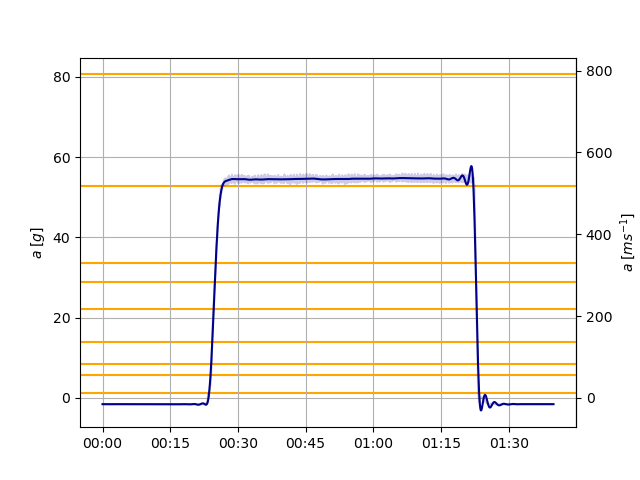

Found sensor offset: 1.00 g / 9.81 m/s^2

Centrifugal acceleration at 6.49 Hz:
         Theory: 2.16 g / 21.14 m/s^2
    Measurement: 55.57 g / 544.9912192549019 m/s^2
     Rel. Error: -96.12 %
     Abs. Error: -53.42 g / -523.85 m/s^2

Centrifugal acceleration at 6.49 Hz:
         Theory: 6.82 g / 66.88 m/s^2
    Measurement: -0.58 g / -5.674407202881151 m/s^2
     Rel. Error: -1278.66 %
     Abs. Error: 7.40 g / 72.56 m/s^2

Centrifugal acceleration at 6.49 Hz:
         Theory: 14.89 g / 146.00 m/s^2
    Measurement: nan g / nan m/s^2
     Rel. Error: nan %
     Abs. Error: nan g / nan m/s^2

Centrifugal acceleration at 6.49 Hz:
         Theory: 23.04 g / 225.90 m/s^2
    Measurement: nan g / nan m/s^2
     Rel. Error: nan %
     Abs. Error: nan g / nan m/s^2

Centrifugal acceleration at 6.49 Hz:
         Theory: 34.60 g / 339.27 m/s^2
    Measurement: nan g / nan m/s^2
     Rel. Error: nan %
     Abs. Error: nan g / nan m/s^2

Centrifugal acceleration at 6.49 Hz:
         Theory: 53

<ipython-input-715-bd4d0359155e>:46: RuntimeWarning: Mean of empty slice.
  ivl_avg = (reassembled_values / mems_lsb_per_g)[idx].mean()
/usr/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [715]:
sampling_rate = 10 # sps, set in firmware
mems_lsb_per_g = 68 # LSBs per 1g for our accelerometer

ivl_start, ivl_end = 0.5, 1
ivl_start, ivl_end = int(ivl_start*60*sampling_rate), int(ivl_end*60*sampling_rate)

fig, ax = plt.subplots()
#ax.axvspan(ivl_start/60/sampling_rate, ivl_end/60/sampling_rate, color='orange', alpha=0.5)

ax.grid()

ts = np.arange(0, len(reassembled_values)) / sampling_rate / 60
ax.plot(ts, reassembled_values / mems_lsb_per_g, color='darkblue', alpha=0.2)
#ax.plot(ts, scipy.signal.savgol_filter(reassembled_values / mems_lsb_per_g, 21, 2) )
sos = scipy.signal.butter(8, 0.5, 'lp', fs=10, output='sos')
filtered = scipy.signal.sosfiltfilt(sos, reassembled_values / mems_lsb_per_g)
ax.plot(ts, filtered, color='darkblue')

g = 9.8066
g_to_ms = lambda x: x * g
ms_to_g = lambda x: x / g

ax.set_ylabel(r'$a\; [g]$')
secax_y = ax.secondary_yaxis(
    'right', functions=(g_to_ms, ms_to_g))
secax_y.set_ylabel(r'$a\; [ms^{-1}]$')

formatter = ticker.FuncFormatter(lambda tick, _pos: f'{int(tick):02d}:{tick*60%60:02.0f}')
ax.xaxis.set_major_formatter(formatter)

r_mems = 55e-3 # radius of our sensor from the axis of rotation in m
le_data = [(0, 50, 3.12), (1,50,5.55), (2,40, 8.2), (3, 30, 10.2), (4,15, 12.5), (5,10, 15.6),
           (6,10, 19.2), (7,11, 11.6), (8,15, 6.49)]
avg_include = [True, True, True, True, True, False, True, True, True]
acc_theory = []
acc_meas = []

for ts_m, ts_s, f_actual in le_data:
    omegan = 2*np.pi*f_actual # angular velocity
    acc = omegan**2 * r_mems # m/s^2
    acc_theory.append(acc / g)
    
    ts_abs = ts_m + ts_s/60
    ivl_w = 0.5
    idx = (ts_abs - ivl_w/2 < ts) & (ts < ts_abs + ivl_w/2)
    ivl_avg = (reassembled_values / mems_lsb_per_g)[idx].mean()
    acc_meas.append(ivl_avg)

# Calculate offset correction. The offset is due to manufacturing imperfections inherent to the device.
# Note that while in the "0Hz" still part of the line at the beginning and end of the trace we see a
# fraction of earth's gravity due to the sensor's position inside the device and the way the device lies
# on the workbench, this offset cancels out once the device is rotating.
#
# Our sensor is specified to have up to +/- 1.0 g offset. This is due to its large +/- 120 g range
# and we're well within that.
#
# The sensor's nonlinearity error is specified as +/- 2 %FS and we're well within that as well.

def fun(x, *args):
    return np.sqrt(np.mean([ (meas - x[0] - theory)**2
                            for theory, meas, inc in zip(acc_theory, acc_meas, avg_include)
                            if inc ]))
res = scipy.optimize.minimize(fun, 1)
sensor_offx = np.abs(res.x[0])

print(f'Found sensor offset: {sensor_offx:.2f} g / {sensor_offx*g:.2f} m/s^2')
print()

for theory, meas, interval in zip(acc_theory, acc_meas, interval_speeds):
    ax.axhline(theory - sensor_offx, color='orange', alpha=1, zorder=1)
    meas += sensor_offx
        
    print(f'Centrifugal acceleration at {f_actual:.2f} Hz:')
    print(f'         Theory: {theory:.2f} g / {theory*g:.2f} m/s^2')
    print(f'    Measurement: {meas:.2f} g / {meas*g} m/s^2')
    print(f'     Rel. Error: {(theory/meas - 1.0) * 100:.2f} %')
    print(f'     Abs. Error: {theory-meas:.2f} g / {(theory-meas)*g:.2f} m/s^2')
    print()

<IPython.core.display.Javascript object>


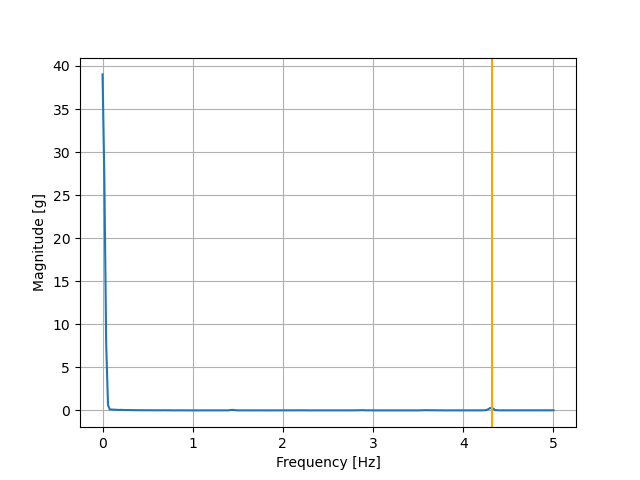

Largest peak at 4.31 Hz / 259 rpm
Mixing product 1 at 5.69 Hz / 341 rpm
Mixing product 2 at 14.31 Hz / 859 rpm
Mixing product 3 at 15.69 Hz / 941 rpm
Mixing product 4 at 24.31 Hz / 1459 rpm
Mixing product 5 at 25.69 Hz / 1541 rpm
Mixing product 6 at 34.31 Hz / 2059 rpm


In [716]:
tsa = np.array(timestamps)
#s_min, s_max = 70, 120
s_min, s_max = 40, 90
speed_idx = (tsa > s_min) & (tsa < s_max)

ts = np.arange(0, len(reassembled_values)) / sampling_rate
fft_idx = (ts > s_min) & (ts < s_max)

N = fft_idx.sum()
T = 1/sampling_rate
x = np.linspace(0.0, N*T, N)
y = reassembled_values[fft_idx] / mems_lsb_per_g # cut out beginning and that time we tapped the thing
y *= scipy.signal.windows.blackmanharris(len(y))
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1/(2*T), N//2)
mag = 2/N * np.abs(yf[:N//2])

fig, ax = plt.subplots()
ax.grid()
ax.plot(xf, mag)
ax.set_ylabel('Magnitude [g]')
ax.set_xlabel('Frequency [Hz]')

peaks, _ = scipy.signal.find_peaks(mag, height=.1, distance=1/T)
assert peaks.any()

peak_data = sorted([ (-mag[idx], xf[idx]) for idx in peaks ])
largest_peak_f = peak_data[0][1]
print(f'Largest peak at {largest_peak_f:.2f} Hz / {largest_peak_f * 60:.0f} rpm')
for i in range(1,4):
    mix1 = i*sampling_rate - largest_peak_f
    mix2 = i*sampling_rate + largest_peak_f
    print(f'Mixing product {2*i-1} at {mix1:.2f} Hz / {mix1 * 60:.0f} rpm')
    print(f'Mixing product {2*i} at {mix2:.2f} Hz / {mix2 * 60:.0f} rpm')

ax.axvline(largest_peak_f, color='orange')

interval: -0.06357678079289661
scores: [0.0005478345240435783, 0.003917745560629984, 0.00382343194410793, 0.006241784699377939, 0.0074863442856081385, 0.008964752044997151, 0.008813512329706083, 0.008780553883453538, 0.008530974440876703]
argmin: 1
Average speed of rotation: 15.73 Hz / 944 rpm


<IPython.core.display.Javascript object>


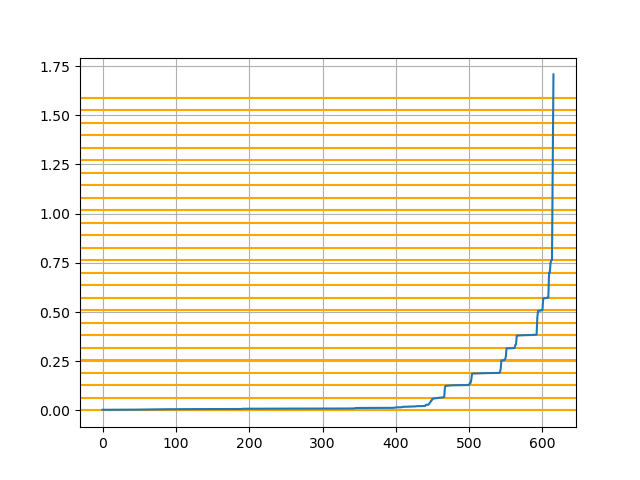

In [717]:
def calc_rspeed_deltas(target_deltas):
    target_deltas = np.array(target_deltas)
    target_deltas = target_deltas[0:-int(len(target_deltas)*0.1)]
    target_deltas = target_deltas[target_deltas > 1/30]
    def fun(x):
        return np.sqrt(np.mean([ ((val + 0.5*x[0]) % x[0] - 0.5*x[0])**2 for val in target_deltas ]))

    #def accept(x_old, x_new, **kwargs):
    #    return 1/30 < x_new[0] and x_new[0] < 1
    res = scipy.optimize.minimize(fun, 0.1)
    #res = scipy.optimize.basinhopping(fun, max(1/largest_peak_f, 0.5), accept_test=accept, stepsize=0.2)
    
    interval = res.x[0]
    scores = [ fun([i*interval]) * (1/(i+10)) for i in range(1, 10) ]
    print('interval:', interval)
    print('scores:', scores)
    argmin = np.argmin(scores)+1
    print('argmin:', argmin)
    interval = np.abs(interval) * argmin
    print(f'Average speed of rotation: {1/interval:.2f} Hz / {60 / interval:.0f} rpm')
    return interval

target_deltas = sorted(np.array(deltas)[speed_idx[:-1]])
interval = calc_rspeed_deltas(target_deltas)
fig, ax = plt.subplots()
ax.grid()
for i in range(int(max(target_deltas)//interval)):
    ax.axhline(i*interval, color='orange')
ax.plot(target_deltas)

<IPython.core.display.Javascript object>


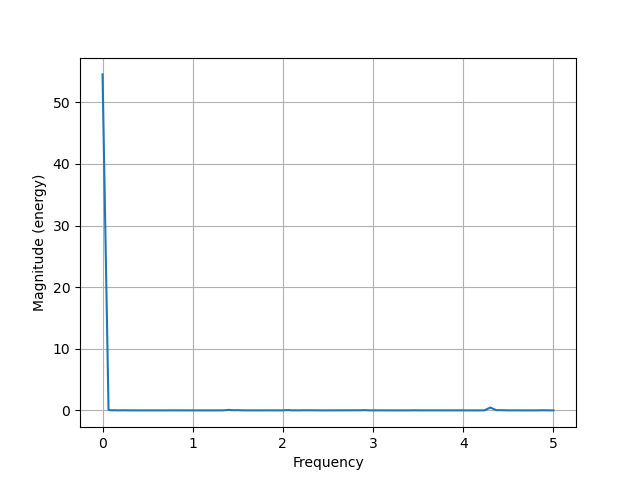

In [718]:
fig, ax = plt.subplots()
ax.grid()
ax.magnitude_spectrum(reassembled_values[ivl_start:ivl_end]/mems_lsb_per_g, Fs=10);

In [719]:
r_mems = 55e-3 # radius of our sensor from the axis of rotation in m
f = largest_peak_f
omega = 2*np.pi*f # angular velocity
centrifugal_acceleration = omega**2 * r_mems # m/s^2

f2 = 1/interval
omega2 = 2*np.pi*f2 # angular velocity
centrifugal_acceleration2 = omega2**2 * r_mems # m/s^2

print(f'Centrifugal acceleration at {largest_peak_f:.2f} Hz: {centrifugal_acceleration:.2f} m/s^2 / {centrifugal_acceleration/g:.2f} g')
print(f'Centrifugal acceleration at {f2:.2f} Hz: {centrifugal_acceleration2:.2f} m/s^2 / {centrifugal_acceleration2/g:.2f} g')

Centrifugal acceleration at 4.31 Hz: 40.42 m/s^2 / 4.12 g
Centrifugal acceleration at 15.73 Hz: 537.19 m/s^2 / 54.78 g


In [720]:
for fn in [0.1, 0.2, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
           11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]:

    omegan = 2*np.pi*fn # angular velocity
    acc = omegan**2 * r_mems # m/s^2
    print(f'Centrifugal acceleration at {fn:.2f} Hz: {acc:.2f} m/s^2 / {acc/g:.2f} g')

Centrifugal acceleration at 0.10 Hz: 0.02 m/s^2 / 0.00 g
Centrifugal acceleration at 0.20 Hz: 0.09 m/s^2 / 0.01 g
Centrifugal acceleration at 0.50 Hz: 0.54 m/s^2 / 0.06 g
Centrifugal acceleration at 1.00 Hz: 2.17 m/s^2 / 0.22 g
Centrifugal acceleration at 1.50 Hz: 4.89 m/s^2 / 0.50 g
Centrifugal acceleration at 2.00 Hz: 8.69 m/s^2 / 0.89 g
Centrifugal acceleration at 2.50 Hz: 13.57 m/s^2 / 1.38 g
Centrifugal acceleration at 3.00 Hz: 19.54 m/s^2 / 1.99 g
Centrifugal acceleration at 3.50 Hz: 26.60 m/s^2 / 2.71 g
Centrifugal acceleration at 4.00 Hz: 34.74 m/s^2 / 3.54 g
Centrifugal acceleration at 4.50 Hz: 43.97 m/s^2 / 4.48 g
Centrifugal acceleration at 5.00 Hz: 54.28 m/s^2 / 5.54 g
Centrifugal acceleration at 6.00 Hz: 78.17 m/s^2 / 7.97 g
Centrifugal acceleration at 7.00 Hz: 106.39 m/s^2 / 10.85 g
Centrifugal acceleration at 8.00 Hz: 138.96 m/s^2 / 14.17 g
Centrifugal acceleration at 9.00 Hz: 175.88 m/s^2 / 17.93 g
Centrifugal acceleration at 10.00 Hz: 217.13 m/s^2 / 22.14 g
Centrifugal

<IPython.core.display.Javascript object>


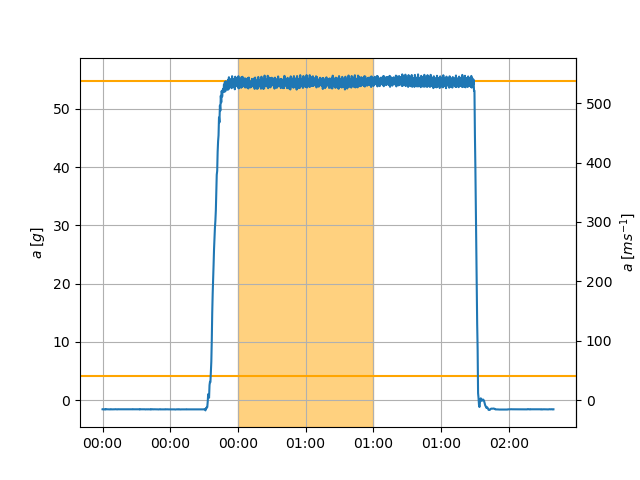

In [721]:
sampling_rate = 10 # sps, set in firmware
mems_lsb_per_g = 68 # LSBs per 1g for our accelerometer

fig, ax = plt.subplots()
ax.axvspan(ivl_start/60/sampling_rate, ivl_end/60/sampling_rate, color='orange', alpha=0.5)
ax.axhline(centrifugal_acceleration/g, color='orange')
ax.axhline(centrifugal_acceleration2/g, color='orange')
interval
ts = np.arange(0, len(reassembled_values)) / sampling_rate / 60
ax.plot(ts, reassembled_values / mems_lsb_per_g )
ax.grid()

g = 9.8066
g_to_ms = lambda x: x * g
ms_to_g = lambda x: x / g

ax.set_ylabel(r'$a\; [g]$')
secax_y = ax.secondary_yaxis(
    'right', functions=(g_to_ms, ms_to_g))
secax_y.set_ylabel(r'$a\; [ms^{-1}]$')

formatter = ticker.FuncFormatter(lambda tick, _pos: f'{tick:02.0f}:{tick*60%1:02.0f}')
ax.xaxis.set_major_formatter(formatter)